# GHG
This notebook will be used to measure indicators for EDGI/EEW's "state of the environment" report ahead of Trump's second administration.

It will pull greenhouse gas emissions reported under EPA's Greenhouse Gas Reporting Program (GHGRP).

GHGRP only covers certain facilities - those who directly emit GHGs and those (e.g. oil refineries) who supply products (e.g. gasoline) that result in GHGs. GHGs from land use change is not included. Still, because it includes both direct emitters (e.g. coal-fired power plants) and suppliers (e.g. of the gas you burn in your car), the GHGRP is estimated to account for 85-90% of all US GHGs. Source: https://www.epa.gov/ghgreporting/ghgrp-and-us-inventory-greenhouse-gas-emissions-and-sinks

In [1]:
%pip install requests
%pip install pandas
%pip install openpyxl
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests, zipfile, io
import os
import numpy as np

In [3]:
# Base dicts to run rest of code on
direct_emissions_field_names = {
    "Direct Point Emitters": "Total reported direct emissions",
    "Onshore Oil & Gas Prod.": "Total reported emissions from Onshore Oil & Gas Production ",
    "Gathering & Boosting": "Total reported emissions from Gathering & Boosting",
    "Transmission Pipelines": "Total reported direct emissions from Transmission Pipelines",
    "LDC - Direct Emissions": "Total reported direct emissions from Local Distribution Companies",
    "SF6 from Elec. Equip.": "Total reported direct emissions from Electrical Equipment Use"
}

# Define supplier-related columns
supplier_columns = [
    "GHG Quantity Associated with Coal-based liquid fuel production",
    "GHG Quantity Associated with Petroleum Products Produced",
    "GHG Quantity Associated with Petroleum Products Imported",
    "GHG Quantity Associated with Petroleum Products Exported",
    "GHG Quantity Associated with Natural Gas Supply",
    "GHG Quantity Associated with Natural Gas Liquids Supply",
    "GHG Quantity Associated with CO2 Supply "
]

direct_columns = [
    "Direct Point Emitters",
    "Onshore Oil & Gas Prod.",
    "Gathering & Boosting",
    "Transmission Pipelines",
    "LDC - Direct Emissions",
    "SF6 from Elec. Equip."
]

In [4]:
# GHGRP
# Access: https://www.epa.gov/system/files/other-files/2024-10/2023_data_summary_spreadsheets.zip
# Data dictionary: https://www.epa.gov/rsei/rsei-data-dictionary-elements-data
# Pull the zip file into this notebook
url = "https://www.epa.gov/system/files/other-files/2024-10/2023_data_summary_spreadsheets.zip"
r = requests.get(url, verify=False)
# Unzip the file
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("")

c:\Users\Ashok\Documents\GitHub\EEW-SOEP\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.epa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [4]:
DATA_DIR = "./"

years = range(2010, 2024)
all_data = []

for year in years:
    filepath = os.path.join(DATA_DIR, f"ghgp_data_{year}.xlsx")
    print(f"Processing {filepath}...")

    year_dfs = []

    # Direct Emitters:
    for clean_name, col_header in direct_emissions_field_names.items():
        retrieve_from_sheet_name = clean_name
        if year < 2018 and retrieve_from_sheet_name == "Direct Point Emitters":
            retrieve_from_sheet_name = "Direct Emitters"

        try:
            df = pd.read_excel(filepath, sheet_name=retrieve_from_sheet_name, header=3)
        except Exception as e:
            print(f"  Skipping sheet {retrieve_from_sheet_name}: {e}")
            continue

        keep_cols = [c for c in ["Facility Id", "Facility Name", col_header] if c in df.columns]
        if len(keep_cols) < 3:
            continue

        df = df[keep_cols].copy()
        df.rename(columns={col_header: clean_name}, inplace=True)
        df["Year"] = year
        df = df.groupby(["Facility Id", "Facility Name", "Year"], as_index=False).sum(numeric_only=True)
        year_dfs.append(df)

    # Suppliers:
    try:
        df_sup = pd.read_excel(filepath, sheet_name="Suppliers", header=3)
        df_sup.replace("confidential", pd.NA, inplace=True)
        
        # Ensure all expected columns exist — add any that are missing as 0.0
        for col in supplier_columns:
            if col not in df_sup.columns:
                df_sup[col] = 0.0

        # Now select columns (guaranteed to exist)
        keep_cols = ["Facility Id", "Facility Name"] + supplier_columns

        df_sup = df_sup[keep_cols].copy()
        df_sup["Year"] = year
        #print(df_sup.head())

        # Aggregate to facility-year level
        df_sup = df_sup.groupby(["Facility Id", "Facility Name", "Year"], as_index=False).sum(numeric_only=False)
        #print(df_sup.head())

        year_dfs.append(df_sup)

        missing = [col for col in supplier_columns if col not in df_sup.columns]
        if missing:
            print(f"  {year}: Missing supplier columns: {missing}")

    except Exception as e:
        print(f"  Skipping Suppliers sheet: {e}")
    
    # list of metadata columns that should appear only once per facility-year
    meta_cols = ["FRS Id", "City", "State", "Zip Code", "Address", "County", "Latitude", "Longitude"]

    # Merge all sheets for the year into one (keep first df fully, drop metadata from later dfs)
    if year_dfs:
        merged_year = year_dfs[0].copy()
        for df_other in year_dfs[1:]:
            df_other = df_other.copy()
            # remove metadata cols from df_other if they already exist in merged_year (avoid duplicate columns)
            cols_to_drop = [c for c in meta_cols if c in df_other.columns and c in merged_year.columns]
            if cols_to_drop:
                df_other = df_other.drop(columns=cols_to_drop)

            merged_year = pd.merge(
                merged_year,
                df_other,
                on=["Facility Id", "Facility Name", "Year"],
                how="outer"
            )
        all_data.append(merged_year)

# Final processing, aligning columns, etc.
aggregated_all_years = pd.concat(all_data, ignore_index=True)

# Ensure every possible column (across all years) exists, filling with NaN if absent
all_columns = sorted(set().union(*(df.columns for df in all_data)))
aggregated_all_years = aggregated_all_years.reindex(columns=all_columns)

# Final aggregation in case of overlapping facility records
# aggregated_all_years = (
#     aggregated_all_years
#     .groupby(["Facility Id", "Facility Name", "Year"], as_index=False)
#     .agg(lambda x: x.sum() if pd.api.types.is_numeric_dtype(x) else x.dropna().iloc[0] if len(x.dropna()) else pd.NA)
# )

print("\n=== Aggregated Emissions (Sample) ===")
print(aggregated_all_years.head())
aggregated_all_years.to_csv("aggregated_emissions_by_facility.csv", index=False)


Processing ./ghgp_data_2010.xlsx...
  Skipping sheet Onshore Oil & Gas Prod.: Worksheet named 'Onshore Oil & Gas Prod.' not found
  Skipping sheet Gathering & Boosting: Worksheet named 'Gathering & Boosting' not found
  Skipping sheet Transmission Pipelines: Worksheet named 'Transmission Pipelines' not found
  Skipping sheet LDC - Direct Emissions: Worksheet named 'LDC - Direct Emissions' not found
  Skipping sheet SF6 from Elec. Equip.: Worksheet named 'SF6 from Elec. Equip.' not found
Processing ./ghgp_data_2011.xlsx...
  Skipping sheet Gathering & Boosting: Worksheet named 'Gathering & Boosting' not found
  Skipping sheet Transmission Pipelines: Worksheet named 'Transmission Pipelines' not found
Processing ./ghgp_data_2012.xlsx...
  Skipping sheet Gathering & Boosting: Worksheet named 'Gathering & Boosting' not found
  Skipping sheet Transmission Pipelines: Worksheet named 'Transmission Pipelines' not found
Processing ./ghgp_data_2013.xlsx...
  Skipping sheet Gathering & Boosting: W

In [5]:
# Load your saved data (if you already wrote it to CSV)
aggregated_all_years = pd.read_csv("aggregated_emissions_by_facility.csv")

# Compute total direct emissions per year
total_per_year = (
    aggregated_all_years
    .groupby("Year")[direct_columns]
    .sum(min_count=1)  # ignore all-NaN rows
    .reset_index()
)

# Create a new column for total of *all* direct emissions combined
total_per_year["Total Direct Emissions"] = total_per_year[direct_columns].sum(axis=1, skipna=True)

total_per_year.head()

total_per_year.to_csv("aggregated_direct_emissions_by_year.csv", index=False)
print("\nSaved to aggregated_direct_emissions_by_year.csv")


Saved to aggregated_direct_emissions_by_year.csv


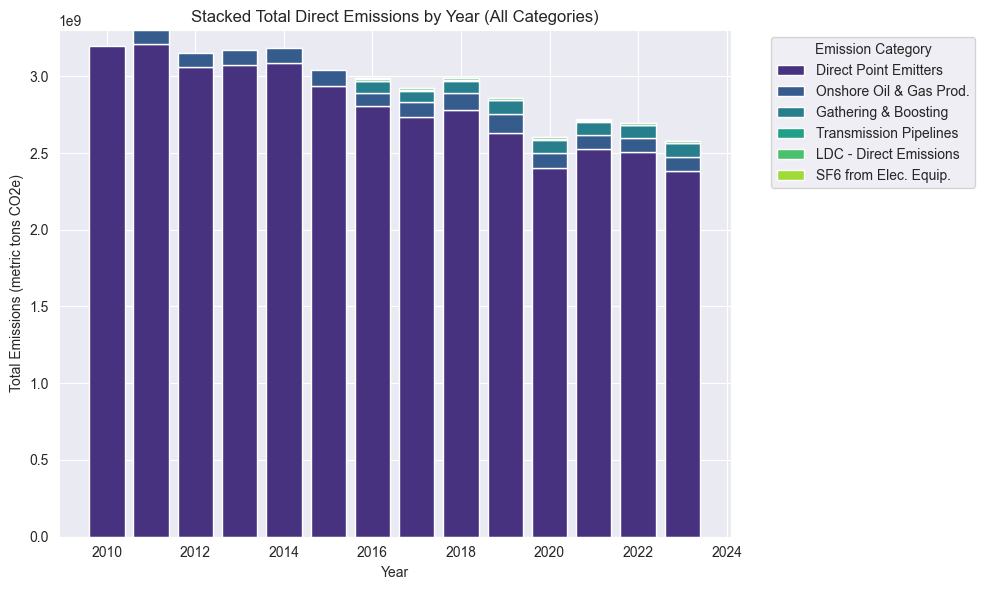

In [6]:
sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))

total_per_year = pd.read_csv("aggregated_direct_emissions_by_year.csv")

bottom_vals = None
colors = sns.color_palette("viridis", n_colors=len(direct_columns))

for i, col in enumerate(direct_columns):
    plt.bar(
        total_per_year["Year"],
        total_per_year[col],
        bottom=bottom_vals,
        color=colors[i],
        label=col
    )
    bottom_vals = (
        total_per_year[col]
        if bottom_vals is None
        else bottom_vals + total_per_year[col]
    )

plt.title("Stacked Total Direct Emissions by Year (All Categories)")
plt.xlabel("Year")
plt.ylabel("Total Emissions (metric tons CO2e)")
plt.legend(title="Emission Category", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


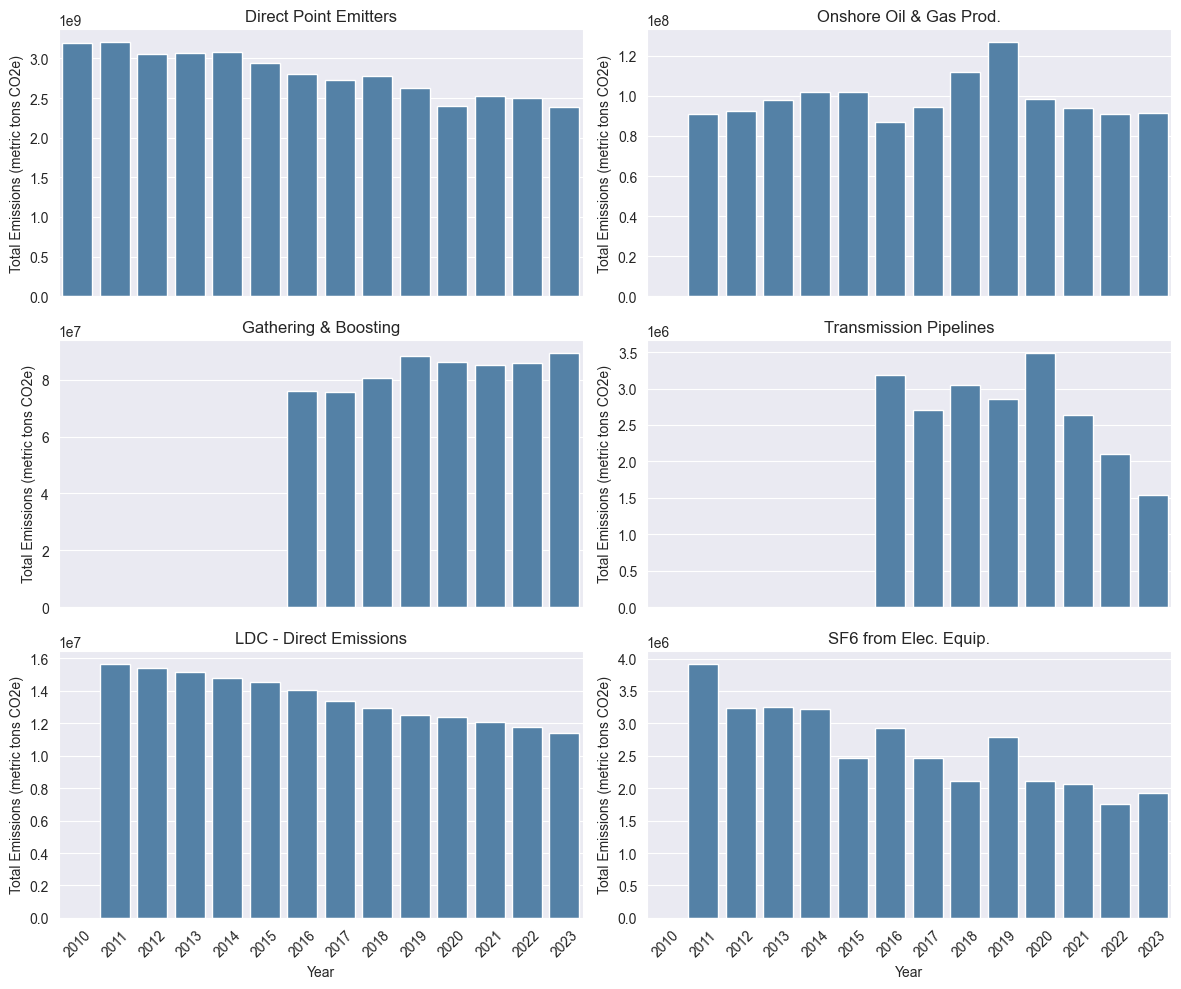

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
axes = axes.flatten()

for i, col in enumerate(direct_columns):
    sns.barplot(
        data=total_per_year,
        x="Year",
        y=col,
        color="steelblue",
        ax=axes[i]
    )
    axes[i].set_title(col)
    axes[i].set_ylabel("Total Emissions (metric tons CO2e)")
    axes[i].set_xlabel("Year")
    axes[i].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


In [9]:
# Similar code as above, but now for suppliers.
# Load your saved data (if you already wrote it to CSV)
aggregated_all_years = pd.read_csv("aggregated_emissions_by_facility.csv")
print(aggregated_all_years.head())
# Compute total direct emissions per year
total_per_year_suppliers = (
    aggregated_all_years
    .groupby("Year")[supplier_columns]
    .sum(min_count=1)  # ignore all-NaN rows
    .reset_index()
)

# Create a new column for total of *all* supplier emissions combined
total_per_year_suppliers["Supplier Emissions"] = total_per_year_suppliers[supplier_columns].sum(axis=1, skipna=True)

total_per_year_suppliers.head()

total_per_year_suppliers.to_csv("aggregated_supplier_emissions_by_year.csv", index=False)
print("\nSaved to aggregated_supplier_emissions_by_year.csv")

   Direct Point Emitters  Facility Id                    Facility Name  \
0             293290.944      1000001  PSE Ferndale Generating Station   
1             108094.104      1000002                Ardagh Glass Inc.   
2              78408.200      1000003                Ardagh Glass Inc.   
3              62346.096      1000004                Ardagh Glass Inc.   
4              74196.872      1000005                Ardagh Glass Inc.   

   GHG Quantity Associated with CO2 Supply   \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

   GHG Quantity Associated with Coal-based liquid fuel production  \
0                                                NaN                
1                                                NaN                
2                                                NaN             

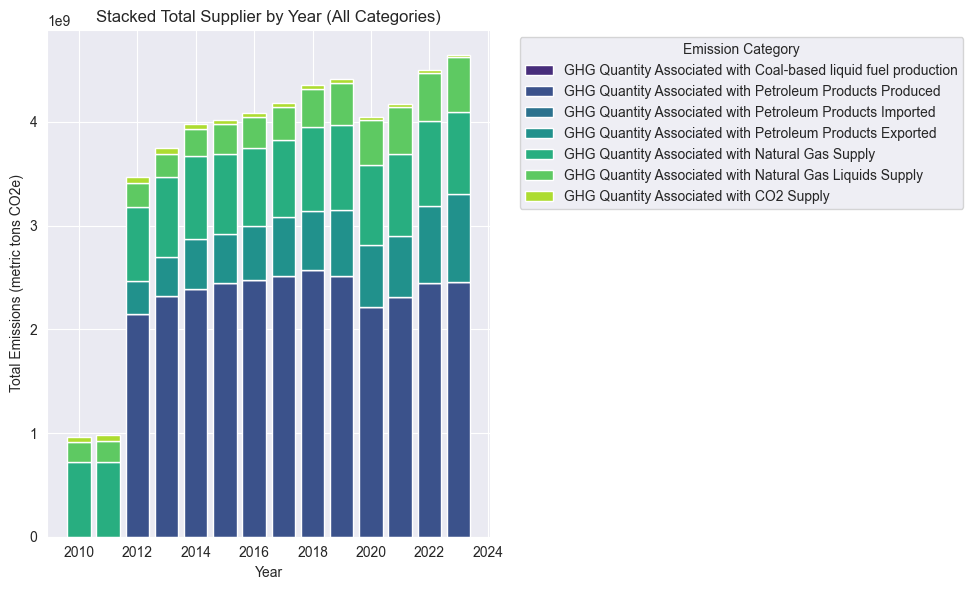

In [7]:
plt.figure(figsize=(10, 6))

total_per_year_suppliers = pd.read_csv("aggregated_supplier_emissions_by_year.csv")

bottom_vals = None
colors = sns.color_palette("viridis", n_colors=len(supplier_columns))

for i, col in enumerate(supplier_columns):
    plt.bar(
        total_per_year_suppliers["Year"],
        total_per_year_suppliers[col],
        bottom=bottom_vals,
        color=colors[i],
        label=col
    )
    bottom_vals = (
        total_per_year_suppliers[col]
        if bottom_vals is None
        else bottom_vals + total_per_year_suppliers[col]
    )

plt.title("Stacked Total Supplier by Year (All Categories)")
plt.xlabel("Year")
plt.ylabel("Total Emissions (metric tons CO2e)")
plt.legend(title="Emission Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


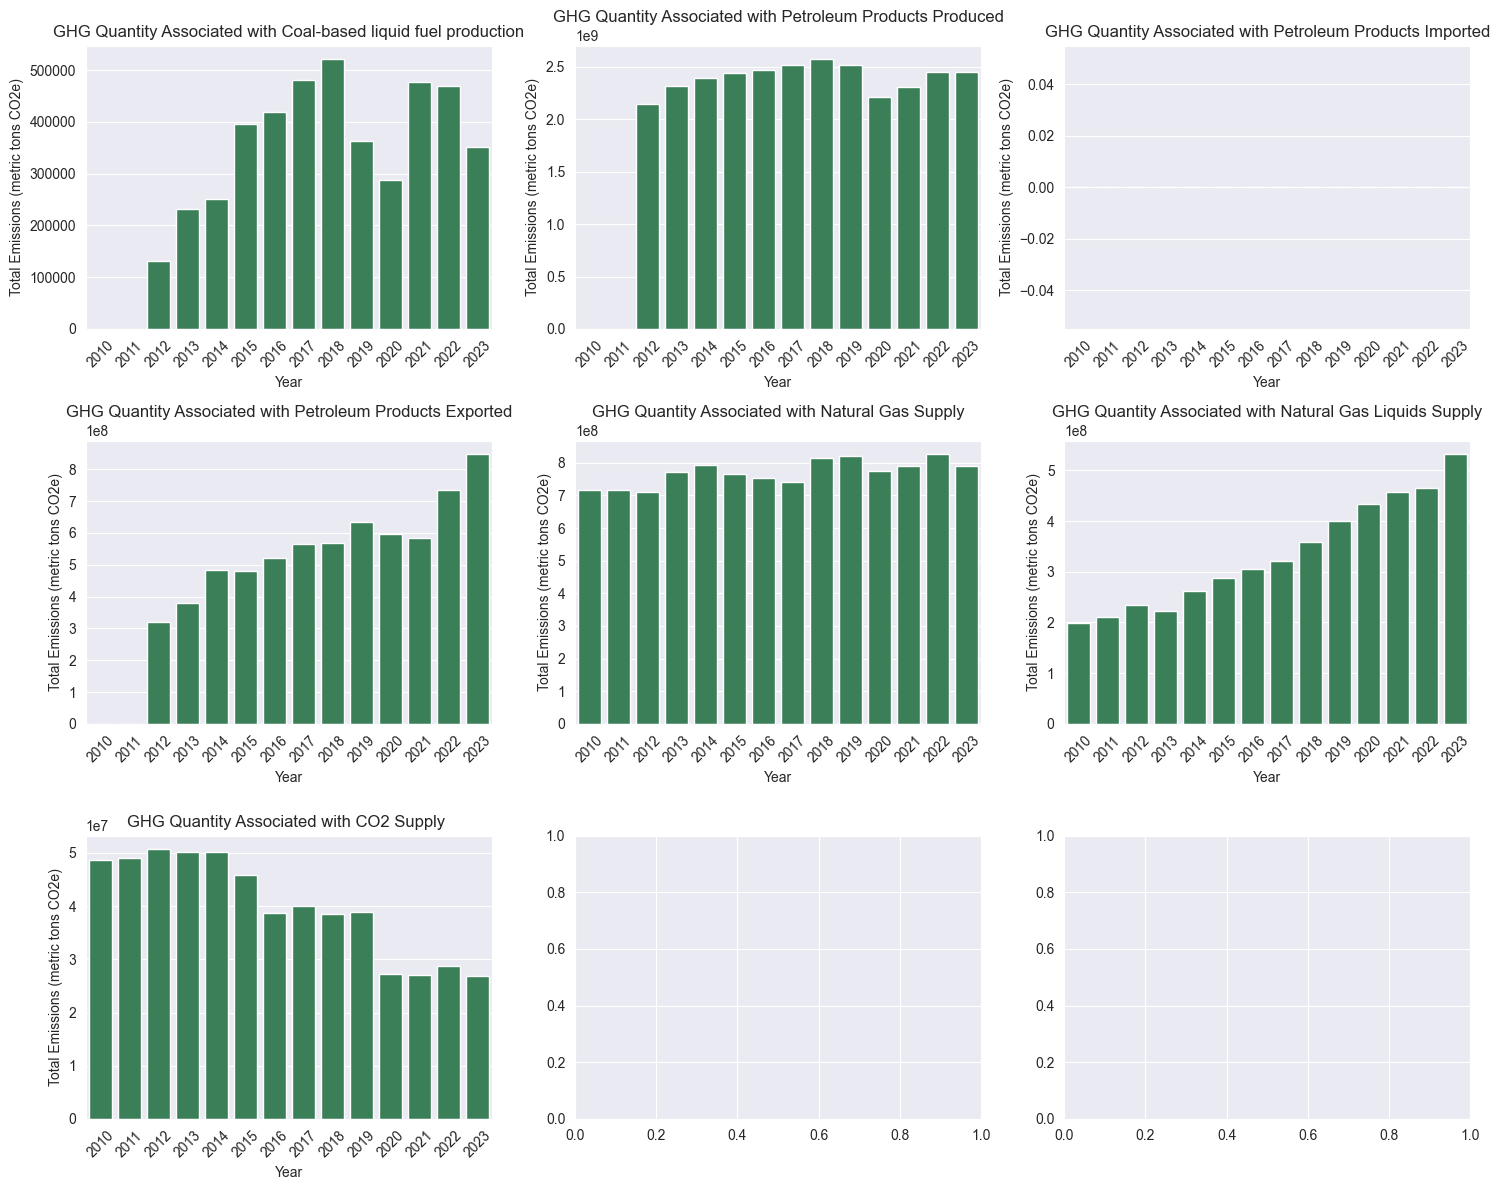

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=False)
axes = axes.flatten()

for i, col in enumerate(supplier_columns):
    sns.barplot(
        data=total_per_year_suppliers,
        x="Year",
        y=col,
        color="seagreen",
        ax=axes[i]
    )
    axes[i].set_title(col)
    axes[i].set_ylabel("Total Emissions (metric tons CO2e)")
    axes[i].set_xlabel("Year")
    axes[i].tick_params(axis="x", rotation=45)

# Hide any unused axes (since we have 7 categories but 9 axes in a 3x3 grid)
# for j in range(len(supplier_columns), len(axes)):
#     axes[j].axis('off')

plt.tight_layout()
plt.show()


In [8]:
print(all_data[0])

      Facility Id                              Facility Name  Year  \
0         1000001            PSE Ferndale Generating Station  2010   
1         1000002                          Ardagh Glass Inc.  2010   
2         1000003                          Ardagh Glass Inc.  2010   
3         1000004                          Ardagh Glass Inc.  2010   
4         1000005                          Ardagh Glass Inc.  2010   
...           ...                                        ...   ...   
6772      1012095     SRI International Cogeneration Project  2010   
6773      1012110                     County of Orange - CUF  2010   
6774      1012116  First Continental International (NJ) Inc.  2010   
6775      1012127                      Ninhua Group Co., Ltd  2010   
6776      1012137                              FSD Group LLC  2010   

      Direct Point Emitters  \
0                293290.944   
1                108094.104   
2                 78408.200   
3                 62346.096   
4   

In [22]:
aggregated_all_years["Total Direct Emissions"] = aggregated_all_years[direct_columns].sum(axis=1, skipna=True)
aggregated_all_years["Total Supplier Emissions"] = aggregated_all_years[supplier_columns].sum(axis=1, skipna=True)
aggregated_all_years.head()

# Create lookup table for Address and other fields
file_2023 = "ghgp_data_by_year_2023.xlsx"
direct_2023 = pd.read_excel(file_2023, sheet_name="Direct Point Emitters", header=3)
supply_2023 = pd.read_excel(file_2023, sheet_name="Suppliers", header=3)

meta_cols = [
    "FRS Id", "Address", "City", "State", "Zip Code",
    "County", "Latitude", "Longitude", "Primary NAICS Code", "Latest Reported Industry Type (subparts)"
]

# Columns needed for merge
key_cols = ["Facility Id", "Facility Name"]

# Keep only key + metadata for each sheet
direct_lu = direct_2023[key_cols + meta_cols + ["Latest Reported Industry Type (sectors)"]].copy()
supply_lu = supply_2023[key_cols + meta_cols].copy()

# Concatenate in priority order: Direct first
lookup = pd.concat([direct_lu, supply_lu], ignore_index=True)

# Drop duplicate keys, keeping first occurrence (Direct wins)
lookup = lookup.drop_duplicates(subset=key_cols, keep="first")
# Lookup table is done.
# Verify "lookup" has no entires with null/empty values for FRS Id
# FRS Id must be there, and an important entry, thus we check this and not necessarily other values
facilities_with_no_FRSID = lookup[(lookup["FRS Id"].isna()) | (lookup["FRS Id"] == "")]
print(facilities_with_no_FRSID)
facilities_with_no_FRSID.to_csv("facilities_with_no_FRSID.csv", index=False)


top_emitters_facility = (
    aggregated_all_years
    .groupby(["Facility Id", "Facility Name"], as_index=False)[
        ["Total Direct Emissions", "Total Supplier Emissions"]
    ]
    .sum(min_count=1)
)

top_emitters_facility = top_emitters_facility.merge(
    lookup,
    on=["Facility Id", "Facility Name"],
    how="left"
)

top_direct_emitters_facility = top_emitters_facility.sort_values("Total Direct Emissions", ascending=False)
top_supplier_emitters_facility = top_emitters_facility.sort_values("Total Supplier Emissions", ascending=False)

print("TOP DIRECT EMITTERS BY FACILITY:\n")
print(top_direct_emitters_facility.head(25))
print("\n\nTOP SUPPLIER EMITTERS BY FACILITY:\n")
print(top_supplier_emitters_facility.head(25))

       Facility Id                                   Facility Name  FRS Id  \
6          1006394                  29-6 #2 Central Delivery Point     NaN   
8          1002885  30-5 Central Delivery Point Compressor Station     NaN   
9          1002707                     31-6 Central Delivery Point     NaN   
23         1013282                                    3M Pittsboro     NaN   
33         1013527                    A.J. Mihm Generating Station     NaN   
...            ...                                             ...     ...   
9952       1013763               Volkswagen Group of America, Inc.     NaN   
9975       1012877                    Washington Imports & Exports     NaN   
9990       1010295                           Whirlpool Corporation     NaN   
9998       1010720                 World Fuel Services Corporation     NaN   
10008      1010967       terrebonne parish consolidated government     NaN   

                             Address           City State  Zip 